# Laboratorio 2
## Pipeline de Machine Learning para Clasificación de Sentimientos con Transformers

En este laboratorio, realizarás una clasificación de sentimiento de reseñas de películas mediante el modelo de transformadores. Como parte de este laboratorio, implementarás un análisis exploratorio de datos para obtener conocimientos sobre la data y su distribución. Posteriormente, los modelos requieren un tokenizer que implementarás personalmente. A continuación, programarás el elemento integral del modelo de transformador, la Mecánica de Atención. Finalmente, combinarás todo y entrenarás al modelo en la tarea de clasificación binaria.

## Tutorial: Cómo activar la GPU gratuita en Google Colab

Para este laboratorio, se recomienda usar la GPU gratuita de Google Colab para acelerar el entrenamiento. Sigue estos pasos:

### Pasos para activar la GPU:

1. **Abre tu notebook en Google Colab**
   - Sube este archivo a Google Drive
   - Haz clic derecho sobre el archivo → "Abrir con" → "Google Colaboratory"

2. **Cambia el tipo de entorno de ejecución**
   - En el menú superior, ve a: **Entorno de ejecución** → **Cambiar tipo de entorno de ejecución**
   - (O en inglés: **Runtime** → **Change runtime type**)

3. **Selecciona la GPU**
   - En "Acelerador por hardware" (Hardware accelerator), selecciona T4 GPU
   - Haz clic en **Guardar** (Save)

4. **Verifica que la GPU esté activa**
   - Ejecuta la siguiente celda para confirmar que tienes acceso a la GPU

### Notas importantes:
- La GPU gratuita tiene límites de uso diario (aproximadamente 12-15 horas por día)
- Si se desconecta, deberás volver a ejecutar todas las celdas
- Guarda tu progreso frecuentemente

In [31]:
# Verificar que la GPU está disponible
import torch
if torch.cuda.is_available():
    print(f"✓ GPU detectada: {torch.cuda.get_device_name(0)}")
    print(f"  Memoria total: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
else:
    print("✗ No se detectó GPU. Por favor, activa la GPU siguiendo los pasos del tutorial anterior.")

✓ GPU detectada: NVIDIA GeForce RTX 4070 Ti SUPER
  Memoria total: 17.17 GB


## Instalación de Dependencias

Primero, instalaremos las bibliotecas necesarias para este laboratorio.

In [ ]:
!pip install datasets

## Imports y Setup Inicial

Importamos todas las bibliotecas necesarias y configuramos las semillas aleatorias para reproducibilidad.

In [70]:
# Initial Setup
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split
import random
import numpy as np
from datasets import load_dataset
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
import re
import math

# Set random seeds for reproducibility
random_seed = 42
torch.manual_seed(random_seed)
random.seed(random_seed)
np.random.seed(random_seed)

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


## Análisis Exploratorio de Datos (EDA)

### 1.- Carga de Datos

Cargaremos el dataset IMDB que contiene reseñas de películas con sentimientos positivos y negativos.

In [39]:
# Load the dataset
dataset = load_dataset('imdb')

texts = list(dataset['train']['text']) + list(dataset['test']['text'])
labels = list(dataset['train']['label']) + list(dataset['test']['label'])

print(f"Total de textos: {len(texts)}")
print(f"Etiquetas únicas: {np.unique(labels)}")

Total de textos: 50000
Etiquetas únicas: [0 1]


### 2.- Visualización de Distribuciones

Analizaremos la distribución de longitudes de las reseñas y la distribución de las etiquetas (positivo/negativo).

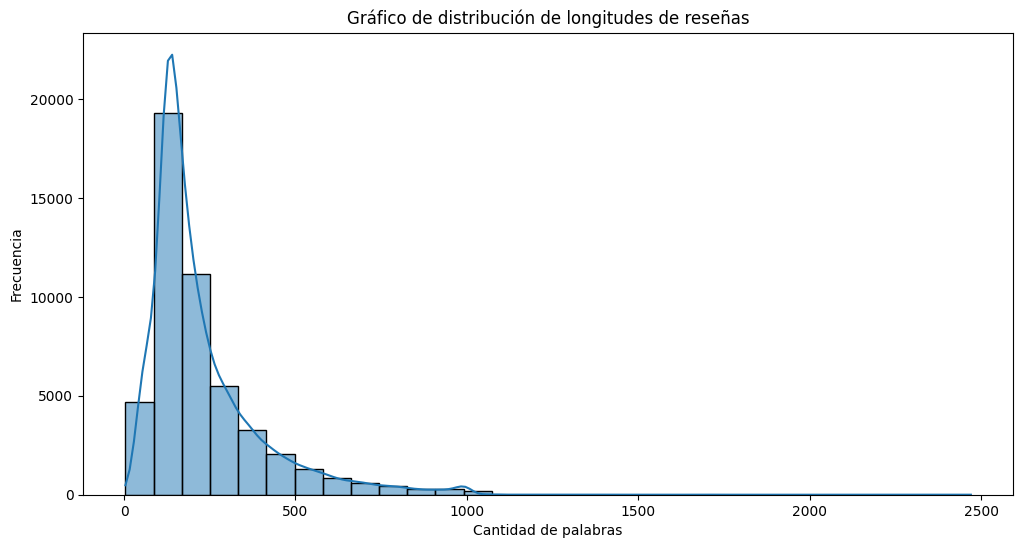

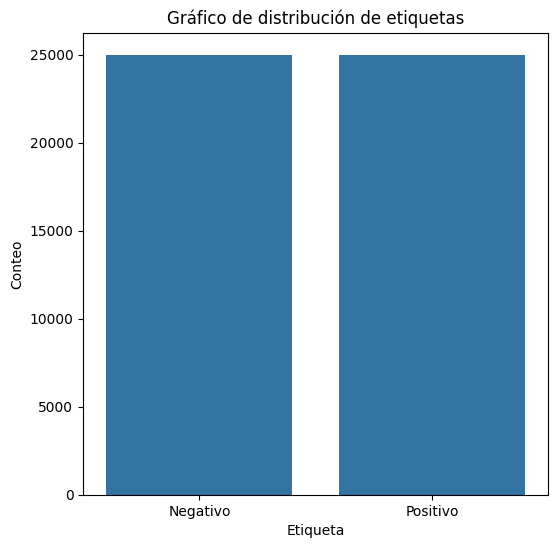

Promedio de longitud de reseñas positivas: 232.85 palabras
Promedio de longitud de reseñas negativas: 229.46 palabras


In [40]:
def word_count(text):
    return len(text.split())

review_lengths = [word_count(text) for text in texts]

# Plot the distribution of review lengths
plt.figure(figsize=(12, 6))
sns.histplot(review_lengths, bins=30, kde=True)
plt.title('Gráfico de distribución de longitudes de reseñas')
plt.xlabel('Cantidad de palabras')
plt.ylabel('Frecuencia')
plt.show()

# Plot the distribution of labels
label_counts = Counter(labels)
plt.figure(figsize=(6, 6))
sns.barplot(x=list(label_counts.keys()), y=list(label_counts.values()))
plt.title('Gráfico de distribución de etiquetas')
plt.xlabel('Etiqueta')
plt.ylabel('Conteo')
plt.xticks(ticks=[0, 1], labels=['Negativo', 'Positivo'])
plt.show()

average_positive_length = np.mean([review_lengths[i] for i in range(len(labels)) if labels[i] == 1])
average_negative_length = np.mean([review_lengths[i] for i in range(len(labels)) if labels[i] == 0])

print(f"Promedio de longitud de reseñas positivas: {average_positive_length:.2f} palabras")
print(f"Promedio de longitud de reseñas negativas: {average_negative_length:.2f} palabras")

## Tareas

### 1: Implementación del Tokenizador

- [ ] Ampliar el tokenizador para que construya un vocabulario de 30.000 palabras y fragmentos de palabra (libro capítulo 12.5).
- [ ] Mostrar el tamaño del vocabulario a lo largo de las iteraciones del algoritmo.

In [45]:
# Tokenizer Implementation

class SimpleTokenizer:
    def __init__(self):
        """
        Inicializa el tokenizador con tokens especiales y estructuras para el vocabulario BPE.
        """
        self.special_tokens = {'[PAD]': 0, '[UNK]': 1}
        self.vocab = {'[PAD]': 0, '[UNK]': 1}
        self.reverse_vocab = {0: '[PAD]', 1: '[UNK]'}
        # Almacenará los merges aprendidos (par -> token unido)
        self.merges = {}

    def get_vocab_stats(self, texts):
        """
        Obtiene las frecuencias de las palabras del corpus y las divide en caracteres.
        Esto es para preparar el corpus para el algoritmo BPE.
        """
        word_counts = Counter()
        for text in texts:
            # Usamos una regex simple para separar palabras o puntuación
            words = re.findall(r'\w+|[^\s\w]', text.lower())
            for word in words:
                word_counts[word] += 1
        
        # Divide las palabras en caracteres + '_' para marcar el fin de palabra 
        splits = {tuple(word) + ('_',): freq for word, freq in word_counts.items()}
        return splits

    def get_pair_frequencies(self, splits):
        """
        Calcula la frecuencia de todos los pares de tokens adyacentes en el corpus.
        """
        pair_freqs = defaultdict(int)
        for token_tuple, freq in splits.items():
            for i in range(len(token_tuple) - 1):
                pair = token_tuple[i:i+2]
                pair_freqs[pair] += freq
        return pair_freqs

    def merge_pair(self, splits, pair_to_merge, new_token):
        """
        Aplica un merge (fusión) a la representación del corpus 'splits'.
        """
        new_splits = {}
        for token_tuple, freq in splits.items():
            new_tuple = []
            i = 0
            while i < len(token_tuple):
                if i < len(token_tuple) - 1 and token_tuple[i:i+2] == pair_to_merge:
                    new_tuple.append(new_token)
                    i += 2
                else:
                    new_tuple.append(token_tuple[i])
                    i += 1
            new_splits[tuple(new_tuple)] = freq
        return new_splits

    def build_vocab(self, texts, target_vocab_size=30000):
        """
        Crea el vocabulario BPE a partir de los textos.
        Sigue el proceso de fusión iterativa descrito en el libro.
        """
        # 1. Preparar el corpus
        splits = self.get_vocab_stats(texts)

        # 2. Inicializar vocabulario con caracteres base 
        alphabet = set()
        for token_tuple in splits:
            alphabet.update(token_tuple)
        
        # Limpiamos y reconstruimos el vocab
        self.vocab = self.special_tokens.copy()
        for char in sorted(list(alphabet)):
            if char not in self.vocab:
                self.vocab[char] = len(self.vocab)
        
        self.merges = {}
        
        print(f"Vocabulario inicial (caracteres): {len(self.vocab)}")

        # 3. Bucle de merges iterativos hasta alcanzar el tamaño objetivo 
        while len(self.vocab) < target_vocab_size:
            pair_freqs = self.get_pair_frequencies(splits)
            if not pair_freqs:
                break # No hay más pares

            # Encuentra el par más frecuente
            best_pair = max(pair_freqs, key=pair_freqs.get)
            
            # Si el par más frecuente es muy raro, paramos.
            if pair_freqs[best_pair] < 2:
                break 

            new_token = "".join(best_pair)
            self.vocab[new_token] = len(self.vocab)
            self.merges[best_pair] = new_token
            
            splits = self.merge_pair(splits, best_pair, new_token)
            
            # Tarea 1, Requisito 2: Mostrar el tamaño del vocabulario
            if len(self.vocab) % 500 == 0:
                print(f"Tamaño del vocabulario alcanzado: {len(self.vocab)}")

        # 4. Construir el vocabulario inverso final
        self.reverse_vocab = {idx: token for token, idx in self.vocab.items()}
        print(f"Construcción de vocabulario finalizada. Tamaño total: {len(self.vocab)}")


    def _tokenize_bpe(self, text):
        """
        Tokeniza un texto nuevo usando los merges BPE aprendidos.
        Esta función reemplaza la lógica del 'tokenize' simple.
        """
        # Pre-procesamiento similar al de build_vocab
        words = re.findall(r'\w+|[^\s\w]', text.lower())
        word_splits = [tuple(word) + ('_',) for word in words]
        
        final_tokens = []
        for split in word_splits:
            # Aplica merges iterativamente, en el orden en que se aprendieron
            for pair, new_token in self.merges.items():
                if len(split) < 2:
                    break
                new_split_word = []
                i = 0
                while i < len(split):
                    if i < len(split) - 1 and split[i:i+2] == pair:
                        new_split_word.append(new_token)
                        i += 2
                    else:
                        new_split_word.append(split[i])
                        i += 1
                split = tuple(new_split_word)
            
            final_tokens.extend(list(split))
        
        return final_tokens

    def encode(self, text, max_length=128):
        """
        Convierte el texto a una lista de IDs de tokens utilizando el vocabulario BPE.
        """
        # Esta es la implementación del "TODO"
        # Usamos el nuevo tokenizador BPE en lugar del .split()
        tokens = self._tokenize_bpe(text)
        
        token_ids = [self.vocab.get(token, self.vocab['[UNK]']) for token in tokens]
        
        # Lógica de padding (la misma que antes)
        if len(token_ids) < max_length:
            token_ids += [self.vocab['[PAD]']] * (max_length - len(token_ids))
        else:
            token_ids = token_ids[:max_length]
        return token_ids

    def decode(self, token_ids):
        """
        Convierte la lista de IDs de tokens a un texto utilizando la reversa_vocabulario.
        """
        # Filtramos [PAD] para una decodificación más limpia
        tokens = [self.reverse_vocab.get(id, '[UNK]') for id in token_ids if id != self.vocab['[PAD]']]
        
        # Unimos los tokens y luego limpiamos los '_' (fin de palabra)
        text = "".join(tokens).replace('_', ' ').strip()
        return text

    @property
    def vocab_size(self):
        return len(self.vocab)

# --- El resto del código del notebook continúa desde aquí ---

simple_tokenizer = SimpleTokenizer()
simple_tokenizer.build_vocab(texts) # ¡Esto tomará un tiempo!
print(f"\nVerificación del tamaño del vocabulario:")
print(f"Tamaño del vocabulario: {simple_tokenizer.vocab_size}")

if 29900 <= simple_tokenizer.vocab_size <= 30100:
    print(f"Vocabulary is correct: {simple_tokenizer.vocab_size}")
else:
    print(f"Vocabulary is incorrect: {simple_tokenizer.vocab_size}")


Vocabulario inicial (caracteres): 160
Tamaño del vocabulario alcanzado: 500
Tamaño del vocabulario alcanzado: 1000
Tamaño del vocabulario alcanzado: 1500
Tamaño del vocabulario alcanzado: 2000
Tamaño del vocabulario alcanzado: 2500
Tamaño del vocabulario alcanzado: 3000
Tamaño del vocabulario alcanzado: 3500
Tamaño del vocabulario alcanzado: 4000
Tamaño del vocabulario alcanzado: 4500
Tamaño del vocabulario alcanzado: 5000
Tamaño del vocabulario alcanzado: 5500
Tamaño del vocabulario alcanzado: 6000
Tamaño del vocabulario alcanzado: 6500
Tamaño del vocabulario alcanzado: 7000
Tamaño del vocabulario alcanzado: 7500
Tamaño del vocabulario alcanzado: 8000
Tamaño del vocabulario alcanzado: 8500
Tamaño del vocabulario alcanzado: 9000
Tamaño del vocabulario alcanzado: 9500
Tamaño del vocabulario alcanzado: 10000
Tamaño del vocabulario alcanzado: 10500
Tamaño del vocabulario alcanzado: 11000
Tamaño del vocabulario alcanzado: 11500
Tamaño del vocabulario alcanzado: 12000
Tamaño del vocabulario

### Prueba del Tokenizador

Verificaremos que el tokenizador funciona correctamente codificando y decodificando un texto de ejemplo.

In [46]:
print("Ejemplo de codificación:")
print(simple_tokenizer.encode("The movie was maravilloso"))
print("\nEjemplo de decodificación:")
print(simple_tokenizer.decode(simple_tokenizer.encode("The movie was maravilloso")))

Ejemplo de codificación:
[169, 263, 253, 497, 42, 1418, 390, 294, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Ejemplo de decodificación:
the movie was maravilloso


In [47]:
print(f"Imprimir 15 de la totalidad del vocabulario de tamaño {simple_tokenizer.vocab_size}")
for idx, key in enumerate(simple_tokenizer.vocab):
    print(f"palabra o fragmento correspondiente '{key}' con su token {simple_tokenizer.vocab[key]}")
    if idx == 15:
        break

Imprimir 15 de la totalidad del vocabulario de tamaño 30000
palabra o fragmento correspondiente '[PAD]' con su token 0
palabra o fragmento correspondiente '[UNK]' con su token 1
palabra o fragmento correspondiente ' con su token 2
palabra o fragmento correspondiente '' con su token 3
palabra o fragmento correspondiente '!' con su token 4
palabra o fragmento correspondiente '"' con su token 5
palabra o fragmento correspondiente '#' con su token 6
palabra o fragmento correspondiente '$' con su token 7
palabra o fragmento correspondiente '%' con su token 8
palabra o fragmento correspondiente '&' con su token 9
palabra o fragmento correspondiente ''' con su token 10
palabra o fragmento correspondiente '(' con su token 11
palabra o fragmento correspondiente ')' con su token 12
palabra o fragmento correspondiente '*' con su token 13
palabra o fragmento correspondiente '+' con su token 14
palabra o fragmento correspondiente ',' con su token 15


## Preparación del Conjunto de Datos

Este conjunto de datos se ha reducido a 1500 desde 50.000 para que puedas desarrollar en una instancia de **Google Colab con GPU**. Con la GPU activada, el entrenamiento será mucho más rápido. Si usas CPU, también será posible pero tomará más tiempo.

Crearemos los conjuntos de entrenamiento, validación y prueba.

In [48]:
# Implementación del conjunto de datos IMDB
class IMDBDataset(Dataset):
    def __init__(self, tokenizer, max_length=128, seed=42):
        dataset = load_dataset('imdb')
        texts, labels = list(dataset['train']['text']) + list(dataset['test']['text']), list(dataset['train']['label']) + list(dataset['test']['label'])
        data = list(zip(texts, labels))
        random.Random(seed).shuffle(data)
        self.texts, self.labels = zip(*data)
        self.texts = self.texts[:1500]
        self.labels = self.labels[:1500]
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        inputs = self.tokenizer.encode(text, max_length=self.max_length)
        return torch.tensor(inputs, dtype=torch.long), label

# longitud de secuencia
max_length = 128
dataset = IMDBDataset(simple_tokenizer, max_length=max_length)

# Dividir el conjunto de datos en conjuntos de entrenamiento, validación y prueba
train_size = 800
val_size = 200
test_size = 500
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(random_seed))

# DataLoader para batchear
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

print(f"Tamaños de los conjuntos - Entrenamiento: {len(train_dataset)}, Validación: {len(val_dataset)}, Prueba: {len(test_dataset)}")

Tamaños de los conjuntos - Entrenamiento: 800, Validación: 200, Prueba: 500


## Modelo

### 2: Mecanismo de Atención

- [ ] Capa de atención unidireccional **SingleHeadAttention** con matrices de Query, Key y Value $Q_q, Q_k, Q_v$ (libro capítulo 12.2)
- [ ] **Ajustado** Punto de dot producto de escala (libro capítulo 12.3.2)

In [65]:
class ScaledDotProductAttention(nn.Module):
    """
    Self-Attention unidireccional (causal) con escalado por raíz de dim_model.
    """
    def __init__(self, dim_model):
        super().__init__()
        self.scale = dim_model ** 0.5

    def forward(self, query, key, value):
        # query, key, value: [batch, seq_len, dim_model]
        scores = torch.matmul(query, key.transpose(-2, -1)) / self.scale  # [batch, seq_len, seq_len]

        # Máscara causal (bloquea posiciones futuras)
        seq_len = scores.size(-1)
        mask = torch.triu(torch.ones(seq_len, seq_len, device=scores.device), diagonal=1).bool()
        scores = scores.masked_fill(mask, float('-inf'))

        attn_weights = F.softmax(scores, dim=-1)  # [batch, seq_len, seq_len]
        output = torch.matmul(attn_weights, value)  # [batch, seq_len, dim_model]

        return output, attn_weights


class SingleHeadAttention(nn.Module):
    """
    Atención unidireccional con una sola cabeza.
    """
    def __init__(self, dim_model):
        super().__init__()
        self.query = nn.Linear(dim_model, dim_model)
        self.key = nn.Linear(dim_model, dim_model)
        self.value = nn.Linear(dim_model, dim_model)
        self.attention = ScaledDotProductAttention(dim_model)
        self.out = nn.Linear(dim_model, dim_model)

    def forward(self, x):
        # x: [batch, seq_len, dim_model]
        Q = self.query(x)
        K = self.key(x)
        V = self.value(x)

        attn_output, _ = self.attention(Q, K, V)  # [batch, seq_len, dim_model]
        output = self.out(attn_output)            # [batch, seq_len, dim_model]
        return output


class MultiHeadAttention(nn.Module):
    """
    Multi-Head Self-Attention con máscara causal integrada.
    Permite que el modelo atienda desde múltiples "cabezas" al mismo tiempo.
    """
    def __init__(self, dim_model, num_heads, dropout=0.1):
        super().__init__()
        assert dim_model % num_heads == 0, "dim_model debe ser divisible por num_heads"

        self.num_heads = num_heads
        self.head_dim = dim_model // num_heads
        self.scale = math.sqrt(self.head_dim)

        # Proyecciones para Q, K, V
        self.q_linear = nn.Linear(dim_model, dim_model)
        self.k_linear = nn.Linear(dim_model, dim_model)
        self.v_linear = nn.Linear(dim_model, dim_model)

        # Capa final después de concatenar las cabezas
        self.out = nn.Linear(dim_model, dim_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        batch_size, seq_len, dim_model = x.size()

        # Proyección Q, K, V
        Q = self.q_linear(x)
        K = self.k_linear(x)
        V = self.v_linear(x)

        # Reorganizar para separar cabezas: [batch, heads, seq, head_dim]
        Q = Q.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        K = K.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        V = V.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)

        # Atención por cabeza
        scores = torch.matmul(Q, K.transpose(-2, -1)) / self.scale

        # Máscara causal
        mask = torch.triu(torch.ones(seq_len, seq_len, device=x.device), diagonal=1).bool()
        scores = scores.masked_fill(mask, float('-inf'))

        attn = F.softmax(scores, dim=-1)
        attn = self.dropout(attn)

        # Salida por cabeza
        out = torch.matmul(attn, V)  # [batch, heads, seq, head_dim]

        # Concatenar cabezas
        out = out.transpose(1, 2).contiguous().view(batch_size, seq_len, dim_model)

        # Proyección final
        return self.out(out)



### 3: Capa del Transformer

- [ ] Unir los elementos de la capa SingleHeadAttention, Block de normalización por capa (nn.LayerNorm) y el bloque de forward feedforward (nn.Linear) con una capa de normalización final (libro capítulo 12.4)
- [ ] No olvidar las conexiones residuales

En general, se recomienda utilizar ReLU y además técnicas de regularización para mejorar la generalización del modelo a los datos de prueba (como Dropout).

In [66]:
class TransformerEncoderLayer(nn.Module):
    """
    Capa del codificador Transformer (unidireccional por usar tu SingleHeadAttention).
    Incluye:
    - Atención con una cabeza
    - Conexiones residuales
    - Normalización de capa
    - FeedForward con ReLU
    - Dropout
    """
    def __init__(self, dim_model, dim_feedforward, dropout=0.1):
        super().__init__()
        
        # 1) Atención
        self.self_attn = SingleHeadAttention(dim_model)
        self.norm1 = nn.LayerNorm(dim_model)
        self.dropout1 = nn.Dropout(dropout)

        # 2) FeedForward
        self.ffn = nn.Sequential(
            nn.Linear(dim_model, dim_feedforward),
            nn.ReLU(),
            nn.Linear(dim_feedforward, dim_model)
        )
        self.norm2 = nn.LayerNorm(dim_model)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, src):
        # src: [batch, seq_len, dim_model]

        # --- Bloque de atención ---
        attn_output = self.self_attn(src)            # [batch, seq_len, dim_model]
        src = src + self.dropout1(attn_output)       # Residual
        src = self.norm1(src)                        # LayerNorm

        # --- Bloque FeedForward ---
        ffn_output = self.ffn(src)                   # [batch, seq_len, dim_model]
        src = src + self.dropout2(ffn_output)        # Residual
        src = self.norm2(src)                        # LayerNorm

        return src

class TransformerEncoderLayerMHA(nn.Module):
    """
    Capa del codificador Transformer pero usando Multi-Head Self-Attention.
    Incluye:
    - Multi-Head Attention
    - Residual + LayerNorm
    - Feed Forward Network (FFN)
    - Residual + LayerNorm
    """
    def __init__(self, dim_model, dim_feedforward, num_heads, dropout=0.1):
        super().__init__()

        # Multi-Head Attention
        self.self_attn = MultiHeadAttention(dim_model, num_heads, dropout)

        # Normalización y dropout después de la atención
        self.norm1 = nn.LayerNorm(dim_model)
        self.dropout1 = nn.Dropout(dropout)

        # Feedforward: dos capas lineales con ReLU
        self.ffn = nn.Sequential(
            nn.Linear(dim_model, dim_feedforward),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(dim_feedforward, dim_model)
        )

        # Normalización y dropout después del FFN
        self.norm2 = nn.LayerNorm(dim_model)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, src):
        # src: [batch, seq_len, dim_model]

        # 1) Multi-Head Attention + Residual + LayerNorm
        attn_output = self.self_attn(src)                # [batch, seq_len, dim_model]
        src = self.norm1(src + self.dropout1(attn_output))

        # 2) FFN + Residual + LayerNorm
        ffn_output = self.ffn(src)
        src = self.norm2(src + self.dropout2(ffn_output))

        return src


### Arquitectura del Modelo

El **SentimentAnalysisModel** básico se proporciona. Este modelo combina todos los componentes anteriores para crear un clasificador de sentimientos.

In [55]:
class SentimentAnalysisModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes):
        super(SentimentAnalysisModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.encoder = TransformerEncoderLayer(embed_dim, hidden_dim)
        self.fc = nn.Linear(embed_dim, num_classes)

    def forward(self, src):
        src = self.embedding(src)
        encoded_output = self.encoder(src)
        pooled_output = encoded_output.mean(dim=1)
        return self.fc(pooled_output)

# Puedes experimentar con diferentes parámetros hiperbásicos, como la embedding o el dimensión oculta.
# Tal como puedes ajustar los parámetros de aprendizaje para mejorar el rendimiento del modelo.
embed_dim = 32
hidden_dim = 128
num_classes = 2
vocab_size = simple_tokenizer.vocab_size
model = SentimentAnalysisModel(vocab_size, embed_dim, hidden_dim, num_classes)

# Test with synthetic data
fake_data = torch.randint(0, vocab_size, (8, max_length))
fake_output = model(fake_data)
assert fake_output.shape == (8, num_classes), "Output shape is incorrect"
print(f"Modelo creado exitosamente. Shape de salida: {fake_output.shape}")
model

Modelo creado exitosamente. Shape de salida: torch.Size([8, 2])


SentimentAnalysisModel(
  (embedding): Embedding(30000, 32)
  (encoder): TransformerEncoderLayer(
    (self_attn): SingleHeadAttention(
      (query): Linear(in_features=32, out_features=32, bias=True)
      (key): Linear(in_features=32, out_features=32, bias=True)
      (value): Linear(in_features=32, out_features=32, bias=True)
      (attention): ScaledDotProductAttention()
      (out): Linear(in_features=32, out_features=32, bias=True)
    )
    (norm1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (ffn): Sequential(
      (0): Linear(in_features=32, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=32, bias=True)
    )
    (norm2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (fc): Linear(in_features=32, out_features=2, bias=True)
)

In [71]:
class TransformerEncoderClassifier(nn.Module):
    """
    Modelo Transformer para clasificación de texto usando:
    - Embeddings + Positional Encoding
    - Varias capas de Transformer con Multi-Head Attention
    - Mean Pooling para obtener representación de la oración
    - Clasificación final
    """

    def __init__(self, vocab_size, dim_model=128,num_heads=4,num_layers=3,dim_feedforward=512,max_len=100,num_classes=2,dropout=0.1,padding_idx=0):

        super().__init__()

        # Embedding
        self.embedding = nn.Embedding(vocab_size, dim_model, padding_idx=padding_idx)

        # Positional Encoding
        self.pos_encoding = PositionalEncoding(dim_model, max_len=max_len)

        # Transformer Encoder layers
        self.layers = nn.ModuleList([
            TransformerEncoderLayerMHA(dim_model, dim_feedforward, num_heads, dropout)
            for _ in range(num_layers)
        ])

        self.dropout = nn.Dropout(dropout)

        # Clasificador final
        self.classifier = nn.Sequential(
            nn.Linear(dim_model, dim_model),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(dim_model, num_classes)
        )

    def forward(self, x):
        """
        x: [batch, seq_len] con IDs de tokens
        """
        # [batch, seq_len, dim_model]
        x = self.embedding(x) * math.sqrt(self.embedding.embedding_dim)
        x = self.pos_encoding(x)

        # Pasar por todas las capas del Transformer
        for layer in self.layers:
            x = layer(x)

        # Mean Pooling ignorando padding (0)
        mask = (x != 0).float().unsqueeze(-1)  # detecta padding
        x = (x * mask).sum(dim=1) / mask.sum(dim=1)  # promedio por secuencia

        # Clasificación final
        return self.classifier(x)


## Fase de Entrenamiento

### 4: Entrenamiento

- [ ] Implementar el mecanismo de detección temprana o otra monitoreo del progreso de aprendizaje
- [ ] Experimentar con tamaños más grandes de modelos y comparar el rendimiento obtenido con la cantidad de parámetros requeridos

In [72]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


best_val_loss = float('inf')
patience = 3  # Nº de épocas sin mejora antes de detener
patience_counter = 0

for epoch in range(50):  # TODO: puedes aumentar a 30–50 para experimentos
    model.train()
    total_loss = 0
    
    for texts, labels in train_loader:
        optimizer.zero_grad()
        output = model(texts)
        loss = criterion(output, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0) # esta
        optimizer.step() 
        total_loss += loss.item()
    
    avg_train_loss = total_loss / len(train_loader)

    # VALIDACIÓN
    model.eval()
    val_loss = 0
    val_correct, val_total = 0, 0
    with torch.no_grad():
        for texts, labels in val_loader:
            outputs = model(texts)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = 100 * val_correct / val_total

    print(f"Epoch {epoch+1}: Train Loss={avg_train_loss:.4f} | Val Loss={avg_val_loss:.4f} | Val Acc={val_accuracy:.2f}%")

    # EARLY STOPPING
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        print(f"No mejora. Paciencia: {patience_counter}/{patience}")

        if patience_counter >= patience:
            print("Early stopping activado. Entrenamiento detenido.")
            break


Epoch 1: Train Loss=0.1437 | Val Loss=1.3539 | Val Acc=62.50%
Epoch 2: Train Loss=0.0990 | Val Loss=1.6342 | Val Acc=61.00%
No mejora. Paciencia: 1/3
Epoch 3: Train Loss=0.0502 | Val Loss=1.8319 | Val Acc=61.00%
No mejora. Paciencia: 2/3
Epoch 4: Train Loss=0.0213 | Val Loss=2.0749 | Val Acc=60.50%
No mejora. Paciencia: 3/3
Early stopping activado. Entrenamiento detenido.


## Análisis de Resultados

### 5: Evaluación en el Conjunto de Test

- [ ] Comparar el rendimiento del modelo con muestras de prueba de diferentes longitudes
- [ ] Bonus: alcanzar una precisión superior al 90%. Es posible que debas incrementar el numero de parámetros y que debas implementar la atención múltiple AutoAtención y multicapa para lograr esto (libro capítulo 12.3.3).

In [58]:
from sklearn.metrics import confusion_matrix
# Test loop
model.eval()
test_correct, test_total = 0, 0
y_true = []
y_pred = []
with torch.no_grad():
    for texts, labels in test_loader:
        outputs = model(texts)
        _, predicted = torch.max(outputs, 1)
        y_pred.append(predicted[0])
        y_true.append(labels[0])
        
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()
test_accuracy = 100 * test_correct / test_total
print(f'Test Accuracy: {test_accuracy:.2f}%')
print("\nMatriz de confusión:")
print(confusion_matrix(y_pred, y_true))

Test Accuracy: 63.20%

Matriz de confusión:
[[119  57]
 [127 197]]


## Despliegue

### 6: Pruebas con Ejemplos Personalizados

- [ ] Intenta crear nuevos ejemplos donde el modelo falla al clasificar correctamente el sentimiento.
- [ ] Experimenta, describe y explica qué ocurre cuando intentas clasificar una crítica de cine en español utilizando tu modelo de transformador.

In [64]:
#review = "The movie was amazing"
review = "I didn’t expect much but it wasn’t bad."
inputs = simple_tokenizer.encode(review, max_length=max_length)
inputs = torch.tensor([inputs], dtype=torch.long)

model.eval()
with torch.no_grad():
    outputs = model(inputs)
    _, predicted_class = torch.max(outputs, 1)

class_labels = {0: "Negative", 1: "Positive"}
predicted_label = class_labels[predicted_class.item()]
print(f"The predicted class for the text '{review}' is: {predicted_label}")

The predicted class for the text 'I didn’t expect much but it wasn’t bad.' is: Positive


## Conclusiones

Analiza los resultados obtenidos:

- ¿Qué tipo de reseñas fueron más difíciles de clasificar para el modelo? ¿A qué crees que se debe?
- ¿Qué mejoras podrías proponer para el modelo o el proceso de entrenamiento?
- ¿Qué sucede cuando pruebas el modelo con texto en español?